# World Cup 2022 Prediction

## Introduction

With the World Cup ongoing at the time of writing this, it will be very interesting to predict the winners. In this notebook, we used past international game results to learn, cross validate, and test a linear regression model that will predict the expected goals for each match. This dataset can be found in Past_International_Matches.csv, which we derived from Kaggle ([FIFA World Cup 2022 ⚽️🏆](https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022)).

We then used this model then simulate the whole competion. This means predicting each game in the group stage to find out who will qualify for the knock out stages, and then use the predefined tournament bracket for this World Cup. We will iterate many simulations to find the chance of each team winning this World Cup.

## Import and Set Up

In this section we will import the necessary libraries, read the dataset, and store it in matrices.

In [96]:
import numpy as np
import pandas as pd
import  math
from scipy import optimize
from itertools import combinations
import seaborn as sns
from matplotlib import pyplot as plt

import sklearn
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, mean_absolute_error, f1_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier


In [97]:
groups = pd.read_csv('groupstage.csv')
data = pd.read_csv('Past_International_Matches_Points.csv')


In [98]:
# data['tvalue_difference'] = data['tvalue_home'] - data['tvalue_away']
data['result'] = (data['home_team_result'] == 'Win') * 3 + (data['home_team_result'] == 'Draw') * 2 + (data['home_team_result'] == 'Lose') * 1

data['neutral'] = (data['neutral_location'] == 'TRUE') * 1

## Training 

In [99]:
X = data.loc[:, ['mean_coeff', 'home_team_fifa_rank', 'away_team_fifa_rank', 'importance','neutral']]
y = data.loc[:,['result']]

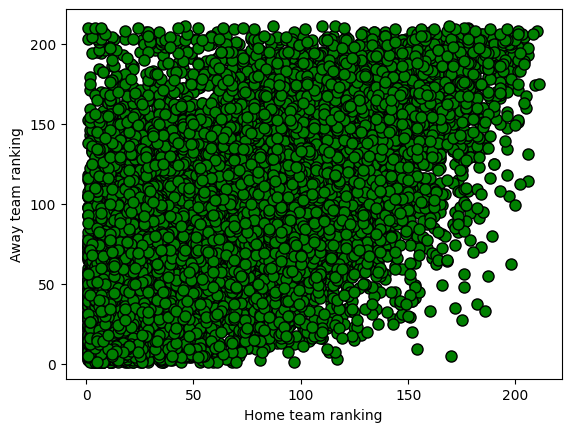

In [189]:
win = data.index[data['result'] == 3]
draw = data.index[data['result'] == 2]
lose = data.index[data['result'] == 1]

# print (X.iloc[win]['home_team_fifa_rank'])

plt.figure()

plt.plot(X.iloc[win]['home_team_fifa_rank'], X.iloc[win]['away_team_fifa_rank'], 'ko', mfc='g', ms=8, mec='k', mew=1)
plt.xlabel('Home team ranking')
plt.ylabel('Away team ranking')
plt.show()


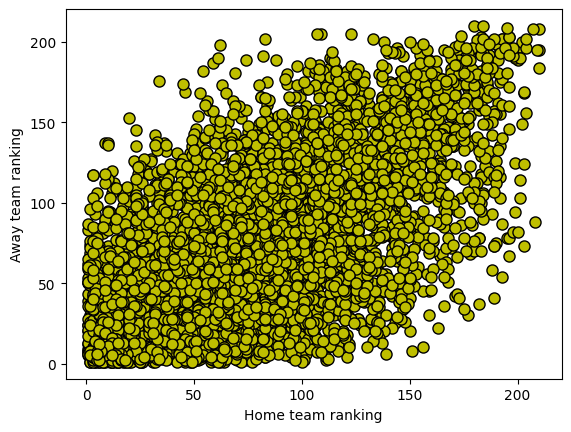

In [191]:
plt.figure()
plt.plot(X.iloc[draw]['home_team_fifa_rank'], X.iloc[draw]['away_team_fifa_rank'], 'ko', mfc='y', ms=8, mec='k', mew=1)
plt.xlabel('Home team ranking')
plt.ylabel('Away team ranking')
plt.show()

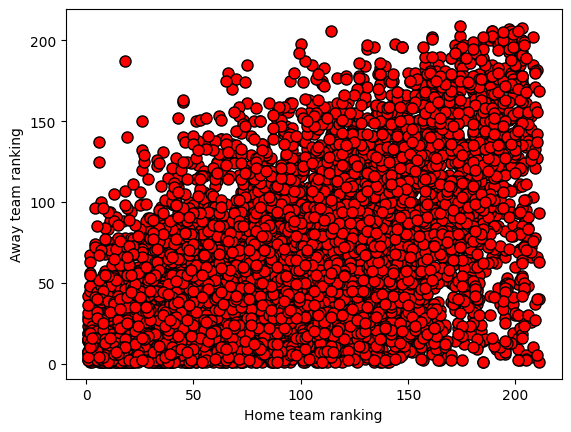

In [192]:
plt.figure()

plt.plot(X.iloc[lose]['home_team_fifa_rank'], X.iloc[lose]['away_team_fifa_rank'], 'ko', mfc='r', ms=8, mec='k', mew=1)
plt.xlabel('Home team ranking')
plt.ylabel('Away team ranking')
plt.show()

In [165]:
def learn(X, y):

    x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size = 0.7, shuffle = True)

    mlp = MLPClassifier()
    mlp.fit(x_train, y_train.values.ravel())

    predict_test = mlp.predict(x_test)
    predict_proba = mlp.predict_proba(x_test)
    predict_train = mlp.predict(x_train)

    acc_mlp = round(mlp.score(x_test, y_test) * 100, 2)
    f1 = f1_score(y_test, predict_test, average='micro')
    mean_error = mean_absolute_error(y_test, predict_test)
    auc_score = metrics.roc_auc_score(y_test, predict_proba, multi_class='ovr')
    print(acc_mlp, f1, mean_error, auc_score)
    return mlp, y_train

learn(X, y)



57.06 0.5705726626724258 0.6327156193395569 0.6932411237160897


(MLPClassifier(),
        result
 7254        1
 9251        1
 13309       1
 22431       1
 11126       3
 ...       ...
 13833       3
 9994        3
 12859       3
 2582        1
 6473        1
 
 [16744 rows x 1 columns])

## Group Stage

The function below simulates all the group stages match.

In [101]:
def splitInGroups(groups_use):
    groups_sorted = groups_use.sort_values(by =['Group', 'points'], ascending = [True, False]) 
    print(groups_sorted)

    A = groups_sorted[groups_sorted['Group'] == 'A']
    print(A)
    B = groups_sorted[groups_sorted['Group'] == 'B']
    print(B)
    C = groups_sorted[groups_sorted['Group'] == 'C']
    print(C)
    D = groups_sorted[groups_sorted['Group'] == 'D']
    print(D)
    E = groups_sorted[groups_sorted['Group'] == 'E']
    print(E)
    F = groups_sorted[groups_sorted['Group'] == 'F']
    print(F)
    G = groups_sorted[groups_sorted['Group'] == 'G']
    print(G)
    H = groups_sorted[groups_sorted['Group'] == 'H']
    print(H)

    return A, B, C, D, E, F, G, H

In [102]:
group_use = groups.set_index(['Country_Name'])

def group_stage(mlp, groups):
    group_use['points'] = 0
    for group in set(groups['Group']):
        print('====Group {}===='.format(group))
        for home, away in combinations (groups.query('Group == "{}"'.format(group)).values, 2):
            print("{} vs {} : " .format(home[0], away[0], end=''))
            row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, 4, 1]]), columns=X.columns)
            home = home[0]
            away = away[0]

            home_coeff = group_use.loc[home, 'conf_coeff']
            away_coeff = group_use.loc[away, 'conf_coeff']
            home_rank = group_use.loc[home, 'Rank']
            away_rank = group_use.loc[away, 'Rank']

            row['mean_coeff'] = (home_coeff + away_coeff)/2
            row['home_team_fifa_rank'] = home_rank
            row['away_team_fifa_rank'] = away_rank
            # row['importance'] = 4

            #PUT MODEL OUTPUT AFTER
            prediction_model = mlp.predict(row)[:][0]
            points = 0 
            if prediction_model == 1 :
                group_use.loc[away, 'points'] += 3
                print("{} wins".format(away))
                
            elif prediction_model == 2:
                group_use.loc[home, 'points'] += 1
                group_use.loc[away, 'points'] += 1
                print("The match ends in a draw")
                
            elif prediction_model == 3 :
                group_use.loc[home, 'points'] += 3
                print("{} wins".format(home))

        
    return splitInGroups(group_use)
    

## Knockout stages

The function `match_winner` predicts which team will win given two teams.

In [103]:
def match_winner(mlp, home, away, importance = 4, neutral = 1): # World Cup importance: 4, always neutral
    row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, importance, neutral]]), columns=X.columns)

    row['mean_coeff'] = (home['conf_coeff'].values[0] + away['conf_coeff'].values[0]) / 2
    row['home_team_fifa_rank'] = home['Rank'].values[0]
    row['away_team_fifa_rank'] = away['Rank'].values[0]

    prediction_model = mlp.predict(row)[:][0]

    if prediction_model == 3:
        print(home.index.values + " vs " + away.index.values + ". Winner " + home.index.values)
        return home, away   # winner, loser
    else:
        print(home.index.values + " vs " + away.index.values + ". Winner " + away.index.values)
        return away, home


### Last 16


In [104]:
def last16(mlp, A, B, C, D, E, F, G, H):
    # get the top two of each group
    a1 = A.iloc[0:1]
    a2 = A.iloc[1:2]

    b1 = B.iloc[0:1]
    b2 = B.iloc[1:2]

    c1 = C.iloc[0:1]
    c2 = C.iloc[1:2]

    d1 = D.iloc[0:1]
    d2 = D.iloc[1:2]

    e1 = E.iloc[0:1]
    e2 = E.iloc[1:2]

    f1 = F.iloc[0:1]
    f2 = F.iloc[1:2]

    g1 = G.iloc[0:1]
    g2 = G.iloc[1:2]

    h1 = H.iloc[0:1]
    h2 = H.iloc[1:2]

    # simulate winners
    l16_1,_ = match_winner(mlp, a1, b2)
    l16_2,_ = match_winner(mlp, c1, d2)
    l16_3,_ = match_winner(mlp, e1, f2)
    l16_4,_ = match_winner(mlp, g1, h2)
    l16_5,_ = match_winner(mlp, b1, a2)
    l16_6,_ = match_winner(mlp, d1, c2)
    l16_7,_ = match_winner(mlp, f1, e2)
    l16_8,_ = match_winner(mlp, h1, g2)

    return l16_1, l16_2, l16_3, l16_4, l16_5, l16_6, l16_7, l16_8

### Quarter finals

In [105]:
def quaterFinals(mlp, l16_1, l16_2, l16_3, l16_4, l16_5, l16_6, l16_7, l16_8):
    qf_1,_ = match_winner(mlp, l16_1, l16_2)
    qf_2,_ = match_winner(mlp, l16_3, l16_4)
    qf_3,_ = match_winner(mlp, l16_5, l16_6)
    qf_4,_ = match_winner(mlp, l16_7, l16_8)

    return qf_1, qf_2, qf_3, qf_4

### Semi-Finals

In [106]:
def semiFinals(mlp, qf_1, qf_2, qf_3, qf_4):
    sf_1, l_1 = match_winner(mlp, qf_1, qf_2)
    sf_2, l_2 = match_winner(mlp, qf_3, qf_4)

    return sf_1, sf_2, l_1, l_2

### Finals

In [107]:
def finals(mlp, sf_1, sf_2, l_1, l_2):
    third_place, fourth_place = match_winner(mlp, l_1, l_2)
    first_place, second_place = match_winner(mlp, sf_1, sf_2)

    return first_place, second_place, third_place, fourth_place

# Simulator

We will use the function above to simulate the competition multiple times.

In [108]:
group_use['Wins'] = 0
group_use['Runners up'] = 0
group_use['Third place'] = 0
group_use['Fourth place'] = 0

for i in range(10):
    print("============================iter" + str(i) + "============================")
    
    mlp,_ = learn(X, y)
    A, B, C, D, E, F, G, H = group_stage(mlp, groups)
    l16_1, l16_2, l16_3, l16_4, l16_5, l16_6, l16_7, l16_8 = last16(mlp, A, B, C, D, E, F, G, H)
    qf_1, qf_2, qf_3, qf_4 = quaterFinals(mlp, l16_1, l16_2, l16_3, l16_4, l16_5, l16_6, l16_7, l16_8)
    sf_1, sf_2, l_1, l_2 = semiFinals(mlp, qf_1, qf_2, qf_3, qf_4)
    first_place, second_place, third_place, fourth_place = finals(mlp, sf_1, sf_2, l_1, l_2)

    group_use.loc[first_place.index.values, 'Wins'] += 1
    group_use.loc[second_place.index.values, 'Runners up'] += 1
    group_use.loc[third_place.index.values, 'Third place'] += 1
    group_use.loc[fourth_place.index.values, 'Fourth place'] += 1

============================iter0============================
51.21 0.5120523895778181 0.603455482792253
====Group C====
Argentina vs Saudi Arabia : 
Argentina wins
Argentina vs Mexico : 
Argentina wins
Argentina vs Poland : 
Argentina wins
Saudi Arabia vs Mexico : 
Mexico wins
Saudi Arabia vs Poland : 
Poland wins
Mexico vs Poland : 
Mexico wins
====Group G====
Brazil vs Serbia : 
Brazil wins
Brazil vs Switzerland : 
Brazil wins
Brazil vs Cameroon : 
Brazil wins
Serbia vs Switzerland : 
Serbia wins
Serbia vs Cameroon : 
Serbia wins
Switzerland vs Cameroon : 
Switzerland wins
====Group D====
France vs Denmark : 
France wins
France vs Tunisia : 
France wins
France vs Australia : 
France wins
Denmark vs Tunisia : 
Denmark wins
Denmark vs Australia : 
Denmark wins
Tunisia vs Australia : 
Tunisia wins
====Group F====
Belgium vs Canada : 
Belgium wins
Belgium vs Morocco : 
Belgium wins
Belgium vs Croatia : 
Belgium wins
Canada vs Morocco : 
Morocco wins
Canada vs Croatia : 
Croatia wins
Mor

In [109]:
group_use[['Wins', 'Runners up', 'Third place', 'Fourth place']]

,Wins,Runners up,Third place,Fourth place
Country_Name,,,,
Qatar,0,0,0,0
Ecuador,0,0,0,0
Senegal,0,0,0,0
Netherlands,0,0,0,0
England,0,1,0,6
IR Iran,0,0,0,0
USA,0,0,0,0
Wales,0,0,0,0
Argentina,6,0,4,0


57.18 0.5718266685244531 0.6268635920300961 0.6969815845904878


<AxesSubplot: >

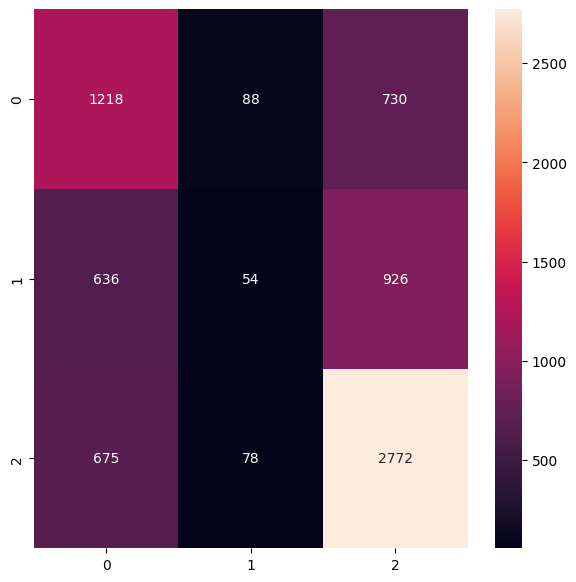

In [173]:
mlp, y_train = learn(X,y)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size = 0.7, shuffle = True)

mlp = MLPClassifier()
mlp.fit(x_train, y_train.values.ravel())

predict_test = mlp.predict(x_test)
predict_proba = mlp.predict_proba(x_test)
predict_train = mlp.predict(x_train)


plt.figure(figsize=(7,7))
cnf_matrix = confusion_matrix(y_test, predict_test)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

